In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import collections
import pickle
from sklearn.cluster import DBSCAN
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.multitest import multipletests

In [4]:
with open("alarm_sequences_for_models.pkl", "rb") as f:
    results = pickle.load(f)

In [5]:
anomaly_data = results['anomaly_detection']
# Example: Use data for machine with serial '3'
machine3_anomaly_sequences = anomaly_data[3]  # List of full sliding-window sequences
# These sequences can be used as inputs to train an autoencoder or other anomaly detection model.

In [6]:
machine3_anomaly_sequences

[[139, 97, 139, 97, 139, 127, 139, 138, 97, 139],
 [97, 139, 97, 139, 127, 139, 138, 97, 139, 97],
 [139, 97, 139, 127, 139, 138, 97, 139, 97, 139],
 [97, 139, 127, 139, 138, 97, 139, 97, 139, 97],
 [139, 127, 139, 138, 97, 139, 97, 139, 97, 139],
 [127, 139, 138, 97, 139, 97, 139, 97, 139, 11],
 [139, 138, 97, 139, 97, 139, 97, 139, 11, 139],
 [138, 97, 139, 97, 139, 97, 139, 11, 139, 11],
 [97, 139, 97, 139, 97, 139, 11, 139, 11, 97],
 [139, 97, 139, 97, 139, 11, 139, 11, 97, 139],
 [97, 139, 97, 139, 11, 139, 11, 97, 139, 97],
 [139, 97, 139, 11, 139, 11, 97, 139, 97, 139],
 [97, 139, 11, 139, 11, 97, 139, 97, 139, 31],
 [139, 11, 139, 11, 97, 139, 97, 139, 31, 97],
 [11, 139, 11, 97, 139, 97, 139, 31, 97, 11],
 [139, 11, 97, 139, 97, 139, 31, 97, 11, 139],
 [11, 97, 139, 97, 139, 31, 97, 11, 139, 97],
 [97, 139, 97, 139, 31, 97, 11, 139, 97, 11],
 [139, 97, 139, 31, 97, 11, 139, 97, 11, 97],
 [97, 139, 31, 97, 11, 139, 97, 11, 97, 139],
 [139, 31, 97, 11, 139, 97, 11, 97, 139, 97],

In [7]:
all_alarms = [alarm for seq_list in anomaly_data.values() for seq in seq_list for alarm in seq]

# Count occurrences of each alarm type
alarm_counts = collections.Counter(all_alarms)

# Convert to DataFrame for visualization
alarm_df = pd.DataFrame(alarm_counts.items(), columns=['Alarm Code', 'Frequency'])
alarm_df = alarm_df.sort_values(by='Frequency', ascending=False)

In [8]:
alarm_df

,Alarm Code,Frequency
2,98,204839
97,11,185388
3,26,160281
4,137,152680
5,31,91352
...,...,...
109,59,10
134,62,10
119,70,10
130,81,10


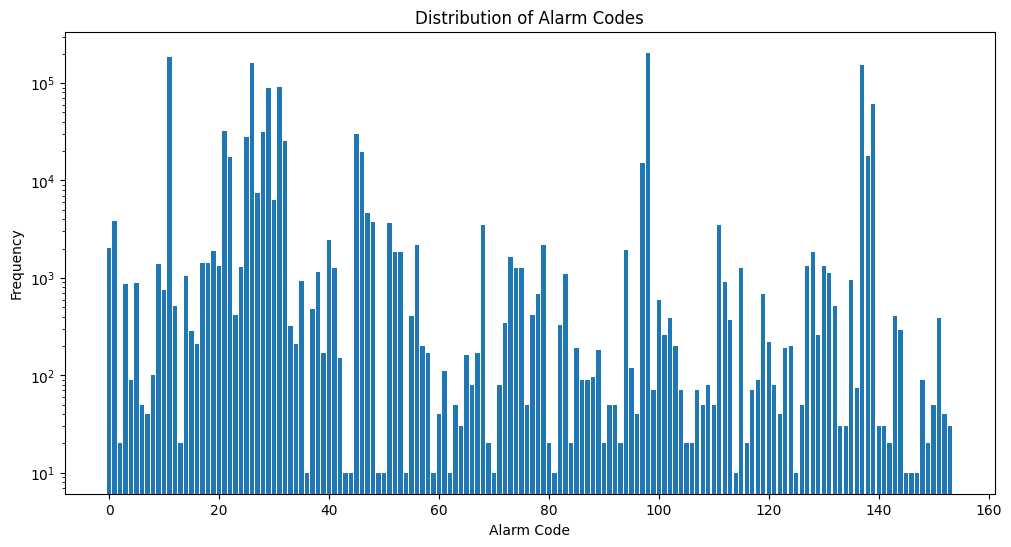

In [9]:
plt.figure(figsize=(12, 6))
plt.bar(alarm_df['Alarm Code'], alarm_df['Frequency'])
plt.xlabel("Alarm Code")
plt.ylabel("Frequency")
plt.title("Distribution of Alarm Codes")
plt.yscale("log")  # Log scale to highlight rare alarms
plt.show()

In [10]:
# Step 1: Extract all machines' alarm sequences
machine_ids = list(anomaly_data.keys())

# Step 2: Encode alarm codes as numerical features
label_encoder = LabelEncoder()

# Collect all alarm codes across machines for encoding
all_alarms = [alarm for machine in machine_ids for seq in anomaly_data[machine] for alarm in seq]
label_encoder.fit(all_alarms)  # Fit encoder on all alarms

# Step 3: Convert sequences to feature vectors
machine_features = {}  # Store feature vectors per machine

for machine in machine_ids:
    encoded_sequences = [label_encoder.transform(seq) for seq in anomaly_data[machine]]
    
    # Convert to a 2D NumPy array (each sequence is a row)
    machine_features[machine] = np.array([np.bincount(seq, minlength=len(label_encoder.classes_)) for seq in encoded_sequences])

# Train Isolation Forest model with std-based thresholding
anomaly_scores = {}  # Store anomaly scores per machine
anomaly_thresholds = {}  # Store dynamic thresholds

for machine, features in machine_features.items():
    if features.shape[0] > 10:  # Ensure enough samples for training
        model = IsolationForest(contamination="auto", random_state=42)
        model.fit(features)

        # Get anomaly scores (lower scores = more anomalous)
        scores = model.decision_function(features)

        # Compute dynamic threshold using mean and std deviation
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        threshold = mean_score - (2 * std_score)  # Set threshold at 2 standard deviations below mean
        anomaly_thresholds[machine] = threshold

        # Classify anomalies dynamically (scores below threshold are anomalies)
        predictions = np.where(scores < threshold, -1, 1)
        anomaly_scores[machine] = predictions

# Store and Display Anomaly Detection Results
anomaly_results_df = pd.DataFrame(
    [(m, sum(scores == -1), len(scores)) for m, scores in anomaly_scores.items()],
    columns=["Machine ID", "Anomalies Detected", "Total Sequences"]
)

# Add anomaly rate column to the DataFrame
anomaly_results_df["Anomaly Rate (%)"] = round((anomaly_results_df["Anomalies Detected"] / anomaly_results_df["Total Sequences"]) * 100,2)



In [11]:
anomaly_results_df

,Machine ID,Anomalies Detected,Total Sequences,Anomaly Rate (%)
0,0,323,6591,4.90
1,1,230,5048,4.56
2,2,261,5681,4.59
3,3,416,8693,4.79
4,4,14,456,3.07
5,5,299,6231,4.80
6,6,1140,23610,4.83
7,7,833,18279,4.56
8,8,106,2780,3.81
9,9,179,4561,3.92


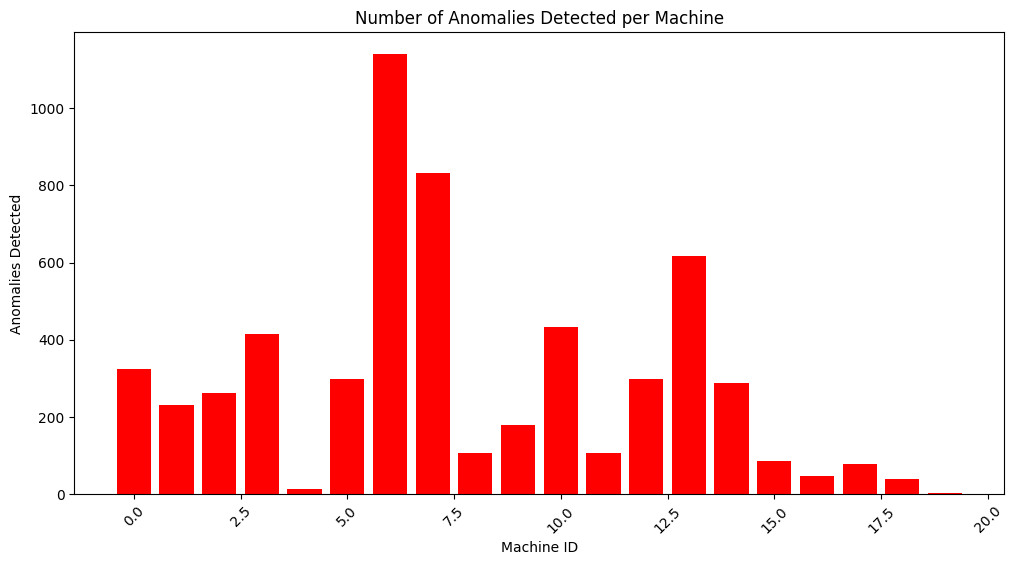

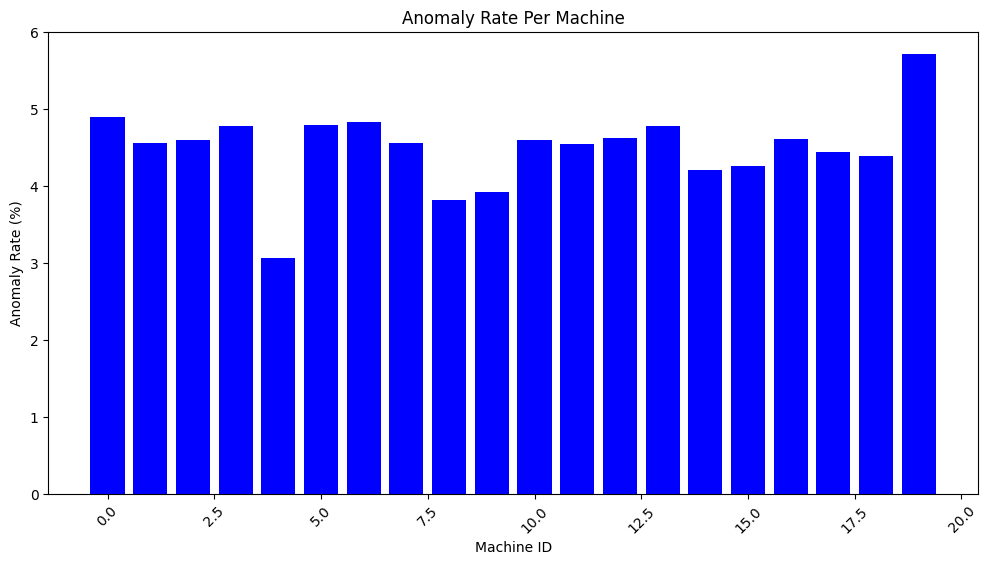

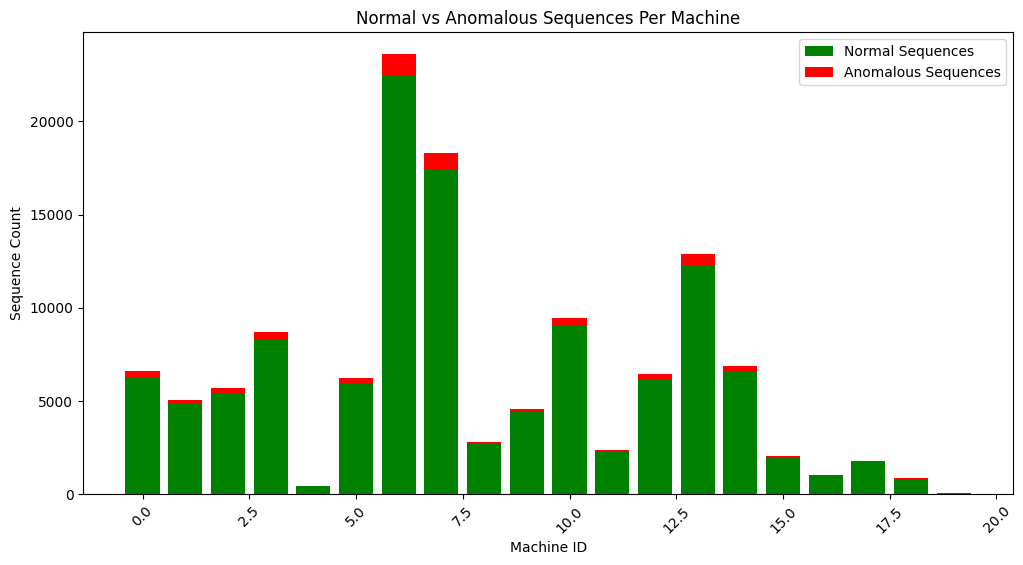

In [12]:
# Step 1: Plot the number of anomalies detected per machine
plt.figure(figsize=(12, 6))
plt.bar(anomaly_results_df["Machine ID"], anomaly_results_df["Anomalies Detected"], color='red')
plt.xlabel("Machine ID")
plt.ylabel("Anomalies Detected")
plt.title("Number of Anomalies Detected per Machine")
plt.xticks(rotation=45)
plt.show()

# Step 2: Plot anomaly rate per machine (Anomalies / Total Sequences)
anomaly_results_df["Anomaly Rate (%)"] = (anomaly_results_df["Anomalies Detected"] / anomaly_results_df["Total Sequences"]) * 100

plt.figure(figsize=(12, 6))
plt.bar(anomaly_results_df["Machine ID"], anomaly_results_df["Anomaly Rate (%)"], color='blue')
plt.xlabel("Machine ID")
plt.ylabel("Anomaly Rate (%)")
plt.title("Anomaly Rate Per Machine")
plt.xticks(rotation=45)
plt.show()

# Step 3: Stacked bar chart for Normal vs Anomalous sequences
normal_sequences = anomaly_results_df["Total Sequences"] - anomaly_results_df["Anomalies Detected"]

plt.figure(figsize=(12, 6))
plt.bar(anomaly_results_df["Machine ID"], normal_sequences, color='green', label="Normal Sequences")
plt.bar(anomaly_results_df["Machine ID"], anomaly_results_df["Anomalies Detected"], color='red', label="Anomalous Sequences", bottom=normal_sequences)
plt.xlabel("Machine ID")
plt.ylabel("Sequence Count")
plt.title("Normal vs Anomalous Sequences Per Machine")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [13]:

  # For FDR control

# Assuming machine_features contains preprocessed data per machine
fdr_results = {}  # Store final anomalies per machine

for machine, features in machine_features.items():
    if features.shape[0] > 10:  # Ensure enough data
        # Train Isolation Forest
        model = IsolationForest(contamination="auto", random_state=42)
        model.fit(features)

        # Get anomaly scores (higher = more normal, lower = more anomalous)
        scores = model.decision_function(features)

        # Convert scores to p-values (normalize scores between 0 and 1)
        p_values = (scores - scores.min()) / (scores.max() - scores.min())

        # Apply FDR correction (Benjamini-Hochberg)
        rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

        # Identify anomalies based on corrected p-values
        anomalies = np.where(rejected, -1, 1)  # -1 for anomaly, 1 for normal

        # Store the results
        fdr_results[machine] = anomalies

# Summarize and analyze results
fdr_summary = pd.DataFrame(
    [(m, sum(scores == -1), len(scores)) for m, scores in fdr_results.items()],
    columns=["Machine ID", "Anomalies Detected (FDR)", "Total Sequences"]
)

# Calculate anomaly rate
fdr_summary["Anomaly Rate (%)"] = (fdr_summary["Anomalies Detected (FDR)"] / fdr_summary["Total Sequences"]) * 100


In [14]:
fdr_summary

,Machine ID,Anomalies Detected (FDR),Total Sequences,Anomaly Rate (%)
0,0,1,6591,0.015172
1,1,1,5048,0.019810
2,2,1,5681,0.017603
3,3,2,8693,0.023007
4,4,2,456,0.438596
5,5,2,6231,0.032098
6,6,1,23610,0.004235
7,7,1,18279,0.005471
8,8,1,2780,0.035971
9,9,1,4561,0.021925
